In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib

In [2]:
df = pd.read_csv("../dataset/mushrooms.csv")

print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

Shape: (8124, 23)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14 

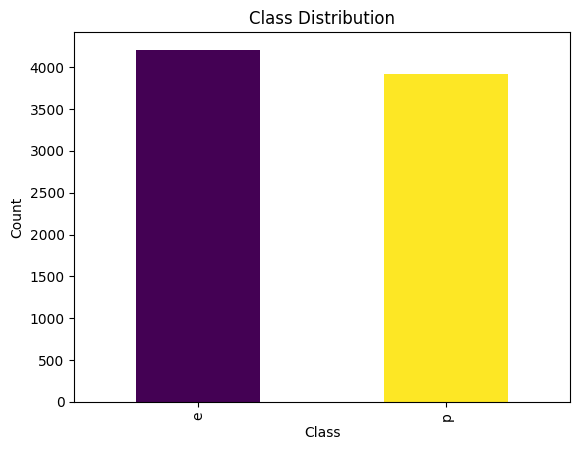

In [3]:
counts = df['class'].value_counts()
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(counts)))

counts.plot(kind='bar', color=colors)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [4]:
K_values = [3, 5, 7, 8, 9, 10, 11, 12, 15, 18, 22]

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

X = df.drop('class', axis=1)
y = df['class']

X_enc = X.apply(LabelEncoder().fit_transform)

mi = mutual_info_classif(X_enc, y)

feature_ranking = (
    pd.Series(mi, index=X.columns)
    .sort_values(ascending=False)
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

models = {
    "DT": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "LR": LogisticRegression(max_iter=1000)
}

from sklearn.model_selection import cross_val_score
import numpy as np

results = {}

for k in K_values:
    top_features = feature_ranking.index[:k]
    X_k = X_enc[top_features]

    scores = {}
    for name, model in models.items():
        cv_score = cross_val_score(
            model, X_k, y,
            cv=5,
            scoring='accuracy'
        ).mean()
        scores[name] = cv_score

    results[k] = scores


summary = pd.DataFrame(results).T
summary['min_score'] = summary.min(axis=1)
summary['mean_score'] = summary.mean(axis=1)

print(summary)

best_k = summary['min_score'].idxmax()
print("Optimal K:", best_k)

selected_features = feature_ranking.index[:best_k]

for i, feat in enumerate(selected_features, start=1):
    print(f"{i}. {feat}")


          DT        RF       KNN       SVM        LR  min_score  mean_score
3   0.912461  0.900638  0.889932  0.849426  0.728226   0.728226    0.834818
5   0.913321  0.902485  0.890055  0.822965  0.750991   0.750991    0.838468
7   0.907409  0.902485  0.873060  0.836872  0.721192   0.721192    0.827035
8   0.907409  0.900514  0.873185  0.843645  0.731532   0.731532    0.831303
9   0.918246  0.901990  0.880569  0.842165  0.840728   0.840728    0.870737
10  0.906423  0.918739  0.879953  0.836256  0.841713   0.836256    0.869890
11  0.912335  0.904946  0.881307  0.844751  0.841836   0.841836    0.871168
12  0.911596  0.912335  0.880691  0.833054  0.856726   0.833054    0.871243
15  0.956670  0.902975  0.882905  0.835261  0.825189   0.825189    0.871365
18  0.917754  0.901990  0.885371  0.837109  0.828636   0.828636    0.866582
22  0.920212  0.897064  0.880816  0.841292  0.830111   0.830111    0.866601
Optimal K: 11
1. odor
2. spore-print-color
3. gill-color
4. ring-type
5. stalk-surface-a

In [5]:
selected_features = feature_ranking.index[:best_k]
X_best = X_enc[selected_features]

In [6]:
from sklearn.model_selection import GridSearchCV

param_grids = {
    "DT": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 3, 5, 8, 10, 15],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 5, 10]
    },

    "RF": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5],
        "max_features": ["sqrt", "log2"]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9, 11, 15],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    },
     "SVM": {
        "C": [0.01, 0.1, 1, 10, 100],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto", 0.01, 0.1, 1]
    },

    "LR": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "solver": ["lbfgs", "liblinear"]
    }
}

In [7]:
best_models = {}
best_scores = {}

for name, model in models.items():
    print(f"\nTuning {name}...")

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    grid.fit(X_best, y)

    best_models[name] = grid.best_estimator_
    best_scores[name] = grid.best_score_

    print("Best CV accuracy:", grid.best_score_)
    print("Best params:", grid.best_params_)



Tuning DT...
Best CV accuracy: 0.9123346722243275
Best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Tuning RF...
Best CV accuracy: 0.9284744221295945
Best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Tuning KNN...
Best CV accuracy: 0.9083943918150815
Best params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

Tuning SVM...
Best CV accuracy: 0.9615993937097386
Best params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Tuning LR...
Best CV accuracy: 0.845035846911709
Best params: {'C': 1, 'solver': 'liblinear'}


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def select_features(X):
    return X[selected_features]

feature_selector = FunctionTransformer(select_features)

pipelines = {}

for name, model in best_models.items():
    pipe = Pipeline([
        ("feature_selection", feature_selector),
        ("classifier", model)
    ])
    pipelines[name] = pipe


In [9]:
os.makedirs("pipelines", exist_ok=True)

for name, pipe in pipelines.items():
    filename = f"pipelines/{name.lower()}_pipeline_k{best_k}.joblib"
    joblib.dump(pipe, filename)
    print(f"Saved pipeline: {filename}")


Saved pipeline: pipelines/dt_pipeline_k11.joblib
Saved pipeline: pipelines/rf_pipeline_k11.joblib
Saved pipeline: pipelines/knn_pipeline_k11.joblib
Saved pipeline: pipelines/svm_pipeline_k11.joblib
Saved pipeline: pipelines/lr_pipeline_k11.joblib
